In [1]:
# !pip install comet-ml

In [2]:
# !pip install shap

# Imports

In [3]:
# Import before anyone else

from comet_ml import Experiment

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report




import shap


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pickle

from collections import Counter

In [4]:
import sys
# sys.path.append('../ift6758/data/')
sys.path.append('../ift6758/visualizations/')

from question_5_plots import *

In [5]:
question_no = 5

# Load Data

In [6]:
df = pd.read_csv(r'final_df.csv', index_col = None)
print(df.columns)


Index(['game_id', 'season', 'season_type', 'event_id', 'home_team',
       'away_team', 'home_team_side_1st_period', 'attacking_team',
       'attacking_player', 'goalie',
       ...
       'attacking_team_Philadelphia Flyers',
       'attacking_team_Pittsburgh Penguins', 'attacking_team_San Jose Sharks',
       'attacking_team_St. Louis Blues', 'attacking_team_Tampa Bay Lightning',
       'attacking_team_Toronto Maple Leafs',
       'attacking_team_Vancouver Canucks',
       'attacking_team_Vegas Golden Knights',
       'attacking_team_Washington Capitals', 'attacking_team_Winnipeg Jets'],
      dtype='object', length=248)


#### Features from Part 4

In [7]:
shot_type_feat = [x for x in df.columns if "shot_type_" in x]
len(shot_type_feat)

7

In [8]:
new_feat = ["game_seconds", "period", 'x_coordinates','y_coordinates', 'shot_type', 'distance_from_net', 'angle_from_net',
               "previous_event_type", 'previous_event_x_coordinates', 'previous_event_y_coordinates',
              'time_since_last_event', 'distance_from_last_event', 'rebound', 'change_in_angle', 'speed',
              'time_since_powerplay_started', '5v5','4v4','3v3','5v4','5v3','4v3','4v5','3v5','3v4']
new_feat.extend(shot_type_feat)

In [9]:
new_feat

['game_seconds',
 'period',
 'x_coordinates',
 'y_coordinates',
 'shot_type',
 'distance_from_net',
 'angle_from_net',
 'previous_event_type',
 'previous_event_x_coordinates',
 'previous_event_y_coordinates',
 'time_since_last_event',
 'distance_from_last_event',
 'rebound',
 'change_in_angle',
 'speed',
 'time_since_powerplay_started',
 '5v5',
 '4v4',
 '3v3',
 '5v4',
 '5v3',
 '4v3',
 '4v5',
 '3v5',
 '3v4',
 'shot_type_Backhand',
 'shot_type_Deflected',
 'shot_type_Slap Shot',
 'shot_type_Snap Shot',
 'shot_type_Tip-In',
 'shot_type_Wrap-around',
 'shot_type_Wrist Shot']

# Data Split

In [10]:
df_train = df[df['season'] != 20192020]
df_train = df_train[df_train['season_type'] == 'R']
df_test = df[df['season'] == 20192020]

## 5.1 Train-Valid

In [11]:
X_1 = df_train[['angle_from_net', 'distance_from_net']]
y_1 = df_train['goal_ind']
#y = y.astype(int)
# (#BLOG)
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X_1,y_1,test_size=0.15,random_state=10, stratify=y_1, shuffle = True)

## 5.2 Train-Valid

In [12]:
obj_features = df_train[new_feat].select_dtypes('object').columns
obj_features

Index(['shot_type', 'previous_event_type'], dtype='object')

In [13]:
def preprocess(df):
    df.drop(columns = ['shot_type'], inplace = True)
    #convert string values to numerical values
    le = LabelEncoder()
    df["previous_event_type"] = le.fit_transform(df["previous_event_type"])
    
    return df

In [14]:
X_2 = df_train[new_feat]
y_2 = df_train['goal_ind']

X_2 = preprocess(X_2)

print(X_2.columns)
#y = y.astype(int)
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X_2,y_2,test_size=0.15,random_state=10, stratify=y_2, shuffle = True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Index(['game_seconds', 'period', 'x_coordinates', 'y_coordinates',
       'distance_from_net', 'angle_from_net', 'previous_event_type',
       'previous_event_x_coordinates', 'previous_event_y_coordinates',
       'time_since_last_event', 'distance_from_last_event', 'rebound',
       'change_in_angle', 'speed', 'time_since_powerplay_started', '5v5',
       '4v4', '3v3', '5v4', '5v3', '4v3', '4v5', '3v5', '3v4',
       'shot_type_Backhand', 'shot_type_Deflected', 'shot_type_Slap Shot',
       'shot_type_Snap Shot', 'shot_type_Tip-In', 'shot_type_Wrap-around',
       'shot_type_Wrist Shot'],
      dtype='object')


# XGBoost Classifier

## 5.1 Baseline XGBoost Model

Train/Validation Setup:
We choose to 'stratify' over the target class variable, due to the high imbalance in it.
It is always desirable to split the dataset into train and validation sets in a way that preserves the same proportions of datapoints in each class as in the original complete dataset. This is important in order for the model to see fair number of examples from both the classes(0,1 in this case) during training.
Shuffle is used to prevent data from having all similar samples together, which can harm generalization capacity later.

### Create Experiment

In [15]:
X_train_2.shape

(264423, 31)

In [16]:
experiment_1 = Experiment(api_key = os.environ.get('COMET_API_KEY'), project_name = "milestone-2", workspace="kleitoun")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kleitoun/milestone-2/fded6fcee487421c9f63a053b4522272



In [17]:
experiment_1 = Experiment(api_key = os.environ.get('COMET_API_KEY'), project_name = "milestone-2", workspace="kleitoun")

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/kleitoun/milestone-2/fded6fcee487421c9f63a053b4522272
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     git metadata        : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET WARNING: Not all initial data has been logged for experiment fded6fcee487421c9f63a053b4522272, call Experiment.end() to ensure that all data to have been logged
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet

### Baseline Model Training

In [18]:
model_1 = XGBClassifier()
 
# fit the model with the training data
model_1.fit(X_train_1,y_train_1)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
COMET WARNING: You must install graphviz to plot tree


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [19]:
preds_1 = model_1.predict(X_valid_1)

### Visualize Feature Importance with SHAP

In [20]:
plot_X_train_1 = X_train_1.rename(columns = {"angle_from_net": "Shot Angle", "distance_from_net": "Shot Distance"})

In [21]:
# explainer = shap.Explainer(model_1)
# shap_values = explainer(plot_X_train_1)

In [22]:
# shap.summary_plot(shap_values, X_train_1)

### Evaluation - XGBoost Baseline (5.1)

In [23]:
# load model file, if pretrained

# model_1 = pickle.load(open("XGBoost_Baseline_model.pickle", 'rb'))


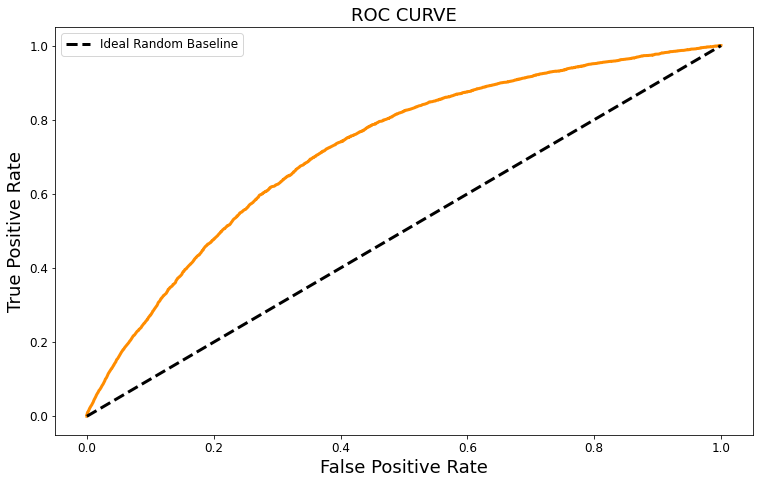

No handles with labels found to put in legend.
No handles with labels found to put in legend.


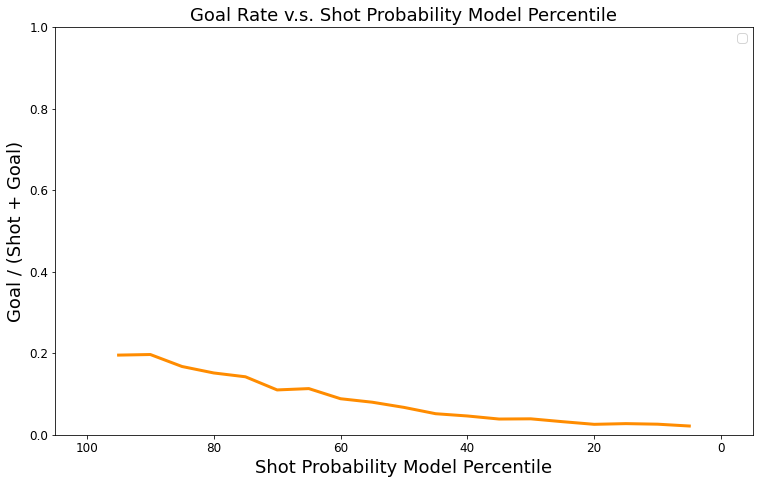

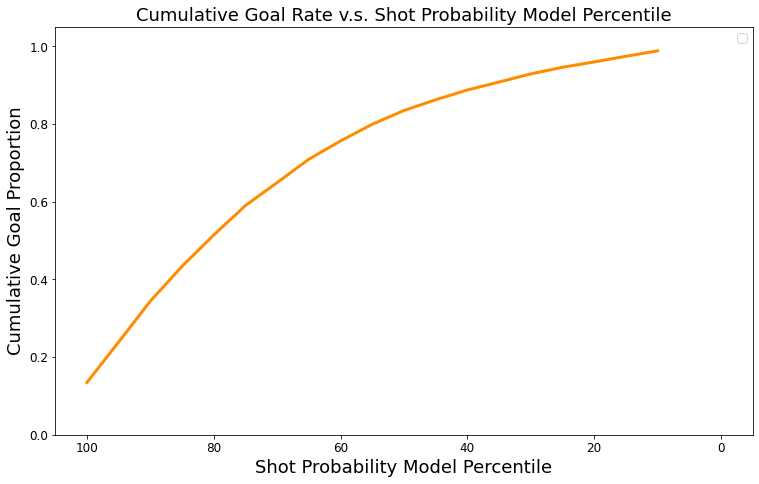

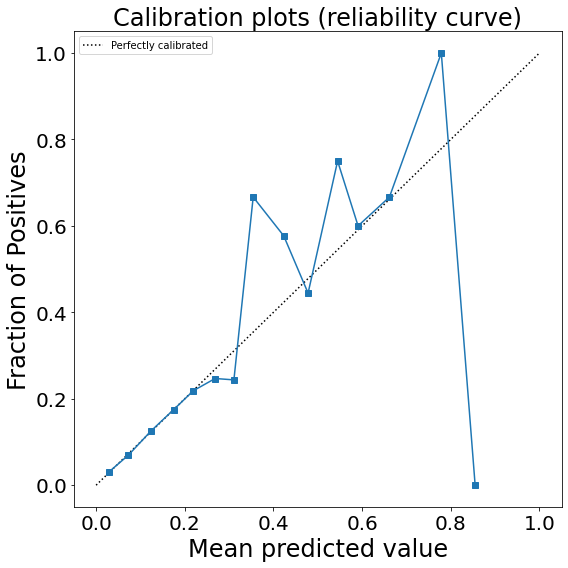

In [24]:
#### USAGE ####
model_name_1 = '_XGBoost_Baseline'

perf_eval = Performance_Eval(model_1,model_name_1, X_train_1, y_train_1, X_valid_1, y_valid_1, question_no = question_no)
roc = perf_eval.get_roc_auc_plot()
grp = perf_eval.get_goal_rate_plot()
crp = perf_eval.get_cum_rate_plot()
cp = perf_eval.get_calibration_plot()

In [25]:
# experiment_1.log_image("Q5_ROC.Curve.png")
# experiment_1.log_image("Q5_Goal_Rate.png")
# experiment_1.log_image("Q5_Cum_Goal.png")
# experiment_1.log_image("Q5_Calibration_Curve.png")

## Log Metrics, Model and Plots

In [26]:
experiment_1.log_figure(figure = roc, figure_name=f'Q{question_no}_{model_name_1}_ROC_curve.png')
experiment_1.log_figure(figure = roc, figure_name=f'Q{question_no}_{model_name_1}_Goal_Rate.png')
experiment_1.log_figure(figure = roc, figure_name=f'Q{question_no}_{model_name_1}_Cum_Goal.png')
experiment_1.log_figure(figure = roc, figure_name=f'Q{question_no}_{model_name_1}_Calibration_Curve.png')


{'web': 'https://www.comet.ml/api/image/download?imageId=bf14825695324321b8556e4ba7422fd5&experimentKey=823acbea18b84cdeb4a1a0996c08200d',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=bf14825695324321b8556e4ba7422fd5&experimentKey=823acbea18b84cdeb4a1a0996c08200d',
 'imageId': 'bf14825695324321b8556e4ba7422fd5'}

In [27]:
y_pred_proba_1 = model_1.predict_proba(X_valid_1)[:,1]
roc_auc =  roc_auc_score(y_valid_1,y_pred_proba_1)
y_pred_1 = model_1.predict(X_valid_1)
accuracy =  accuracy_score(y_valid_1, y_pred_1)
report = classification_report(y_valid_1, y_pred_1, output_dict=True)

print(roc_auc, accuracy)
report
#result: 0.7163373991488216 0.9062212030945288

0.7199331624990181 0.9063926451364036


{'0': {'precision': 0.9064811440087472,
  'recall': 0.9998581124222574,
  'f1-score': 0.9508827167435061,
  'support': 42287},
 '1': {'precision': 0.7,
  'recall': 0.0031992687385740404,
  'f1-score': 0.006369426751592357,
  'support': 4376},
 'accuracy': 0.9063926451364036,
 'macro avg': {'precision': 0.8032405720043736,
  'recall': 0.5015286905804157,
  'f1-score': 0.47862607174754923,
  'support': 46663},
 'weighted avg': {'precision': 0.8871175907399415,
  'recall': 0.9063926451364036,
  'f1-score': 0.8623073967468361,
  'support': 46663}}

In [28]:
metrics = {
    "roc_auc": roc_auc,
    "accuracy": accuracy,
    "classification report": report
}

In [29]:
experiment_1.log_metrics(metrics)

COMET WARNING: Cannot safely convert {'0': {'precision': 0.9064811440087472, 'recall': 0.9998581124222574, 'f1-score': 0.9508827167435061, 'support': 42287}, '1': {'precision': 0.7, 'recall': 0.0031992687385740404, 'f1-score': 0.006369426751592357, 'support': 4376}, 'accuracy': 0.9063926451364036, 'macro avg': {'precision': 0.8032405720043736, 'recall': 0.5015286905804157, 'f1-score': 0.47862607174754923, 'support': 46663}, 'weighted avg': {'precision': 0.8871175907399415, 'recall': 0.9063926451364036, 'f1-score': 0.8623073967468361, 'support': 46663}} object to a scalar value, using its string representation for logging.


In [30]:
pickle.dump(model_1, open("XGBoost_Baseline_model.pickle", 'wb'))
t = pickle.load(open("XGBoost_Baseline_model.pickle", 'rb'))

experiment_1.log_model(name = "XGBoost_Baseline_model", file_or_folder = "XGBoost_Baseline_model.pickle")

{'web': 'https://www.comet.ml/api/asset/download?assetId=c42c3c12c53f4595b55db34224e0599a&experimentKey=823acbea18b84cdeb4a1a0996c08200d',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=c42c3c12c53f4595b55db34224e0599a&experimentKey=823acbea18b84cdeb4a1a0996c08200d',
 'assetId': 'c42c3c12c53f4595b55db34224e0599a'}

In [31]:
experiment_1.end

<bound method BaseExperiment.end of <comet_ml.Experiment object at 0x7f8d589d60a0>>

In [32]:
experiment_1.url
#'https://www.comet.ml/kleitoun/milestone-2/b2e8d79ab6fe40cb8dfef23d74c070b8'

'https://www.comet.ml/kleitoun/milestone-2/823acbea18b84cdeb4a1a0996c08200d'

## 5.2

### Create Experiment

In [33]:
experiment_2 = Experiment(api_key = os.environ.get('COMET_API_KEY'), 
                        project_name = "milestone-2", 
                        workspace="kleitoun")

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/kleitoun/milestone-2/823acbea18b84cdeb4a1a0996c08200d
COMET INFO:   Metrics:
COMET INFO:     accuracy              : 0.9063926451364036
COMET INFO:     classification report : {"0": {"f1-score": 0.9508827167435061, "precision": 0.9064811440087472, "recall": 0.9998581124222574, "support": 42287}, "1": {"f1-score": 0.006369426751592357, "precision": 0.7, "recall": 0.0031992687385740404, "support": 4376}, "accuracy": 0.9063926451364036, "macro avg": {"f1-score": 0.47862607174754923, "precision": 0.8032405720043736, "recall": 0.5015286905804157, "support": 46663}, "weighted avg": {"f1-score": 0.8623073967468361, "precision": 0.8871175907399415, "recall": 0.9063926451364036, "support": 46663}}
COMET INFO:     roc_auc               : 0.7199331624990181


### Remove NaNs and Infs

In [34]:
def impute_df(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    return df

In [35]:
X_train_2 = impute_df(X_train_2)

### Train a vanilla XGBoost Classifier

In [36]:
########## WITH ONLY Q4 features
model_2 = XGBClassifier()
 
# fit the model with the training data
model_2.fit(X_train_2,y_train_2)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [37]:
preds_2 = model_2.predict(X_valid_2)

In [38]:
y_pred_proba_2 = model_2.predict_proba(X_valid_2)[:,1]
roc_auc =  roc_auc_score(y_valid_2,y_pred_proba_2)
y_pred_2 = model_2.predict(X_valid_2)
accuracy =  accuracy_score(y_valid_2, y_pred_2)
report = classification_report(y_valid_2, y_pred_2, output_dict=True)

print(roc_auc, accuracy)

# result: 0.7653420509819099 0.9046782247176564

0.766325874565934 0.9059640400317168


# Hyper-paramter Tuning

In [39]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

In [40]:
# A parameter grid for XGBoost
params = {
    'n_estimators': [150, 300,500],
    'learning_rate': [0.3, 0.2, 0.1],
    'max_depth': list(range(16,30,2))
}

In [41]:
# %%time
# folds = 3
# param_comb = 5

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
# # random search is said to be faster and more efficient at times
# random_search = RandomizedSearchCV(model_2, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train_2,y_train_2), verbose=3, random_state=1001 )
# # random_search = GridSearchCV(model_2, params, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train_2,y_train_2), verbose=3)


# random_search.fit(X_train_2,y_train_2)

# hp_params = random_search.best_params_


In [42]:
hp_params = {'n_estimators': 150,
    'learning_rate': 0.3,
    'max_depth': 18}
model_2_hmtuned = XGBClassifier(**hp_params)
model_2_hmtuned.fit(X_train_2, y_train_2)

# model_2_hmtuned = model_2_hmtuned.best_estimator_


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=18, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
y_pred_proba_2 = model_2_hmtuned.predict_proba(X_valid_2)[:,1]
roc_auc =  roc_auc_score(y_valid_2,y_pred_proba_2)
y_pred_2 = model_2_hmtuned.predict(X_valid_2)
accuracy =  accuracy_score(y_valid_2, y_pred_2)
report = classification_report(y_valid_2, y_pred_2, output_dict=True)

print(roc_auc, accuracy)

# result: 0.7265493652260179 0.9025994899599254

0.7281630716265527 0.9031566765960183


In [44]:
# experiment_2.log_parameters(hp_params)

## Visualize Hyperparameter Tuning Importance

#### Visualizing a few combinations, for example

In [45]:
param_list = [{'n_estimators': 150,
    'learning_rate': 0.3,
    'max_depth': 18, 'gamma': 2},
              {'n_estimators': 300,
    'learning_rate': 0.1,
    'max_depth': 30, 'gamma': 2},
              {'n_estimators': 150,
    'learning_rate': 0.3,
    'max_depth': 18}, 
             {'n_estimators': 300,
    'learning_rate': 0.1,
    'max_depth': 30, 'gamma': 2, 'min_child_weight': 0.25}]

In [46]:
# names = ['parameter set 1', 'parameter set 2', 'parameter set 3']
classifiers = [XGBClassifier(**param_list[0]),
               XGBClassifier(**param_list[1]),
               XGBClassifier(**param_list[2]),
               XGBClassifier(**param_list[3])
               ]

m1 = classifiers[0].fit(X_train_2, y_train_2)
m2 = classifiers[1].fit(X_train_2, y_train_2)
m3 = classifiers[2].fit(X_train_2, y_train_2)
m4 = classifiers[3].fit(X_train_2, y_train_2)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


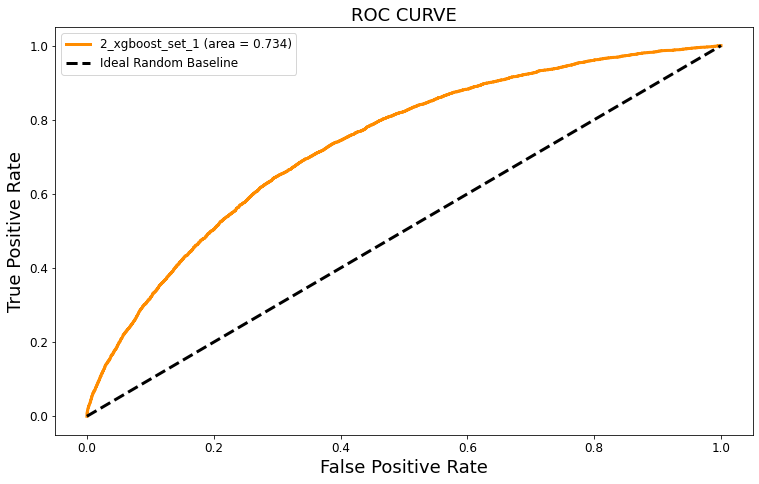

In [47]:
model_name_2 = "2_xgboost_set_1"
perf_eval = Performance_Eval(m1, model_name_2, X_train_2, y_train_2, X_valid_2, y_valid_2,question_no = question_no)
roc_set_1 = perf_eval.get_roc_auc_plot()

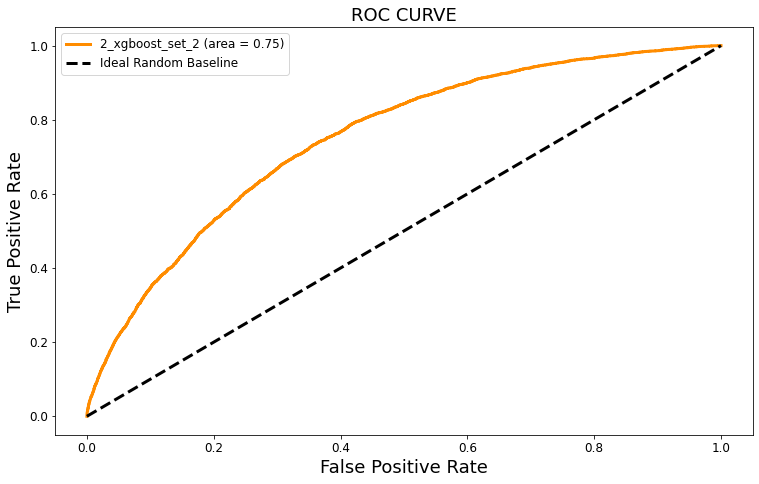

In [48]:
model_name_3 = "2_xgboost_set_2"
perf_eval = Performance_Eval(m2, model_name_3, X_train_2, y_train_2, X_valid_2, y_valid_2,question_no = question_no)
roc_set_2 = perf_eval.get_roc_auc_plot()

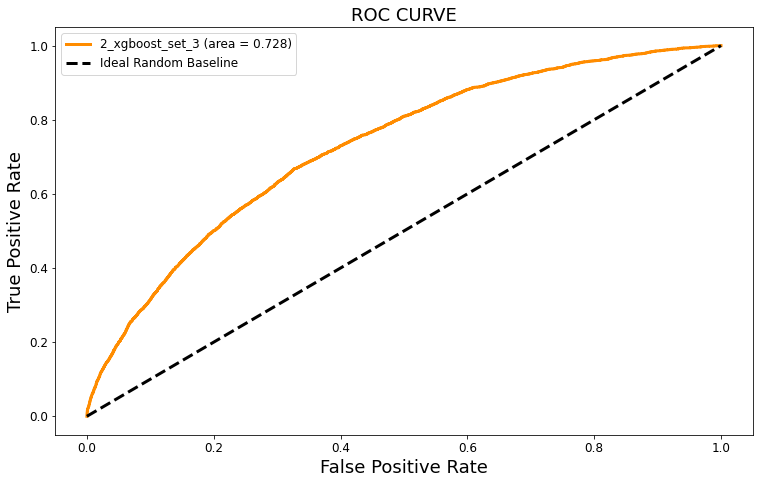

In [49]:
model_name_4 = "2_xgboost_set_3"
perf_eval = Performance_Eval(m3,model_name_4, X_train_2, y_train_2, X_valid_2, y_valid_2,question_no = question_no)
roc_set_3 = perf_eval.get_roc_auc_plot()

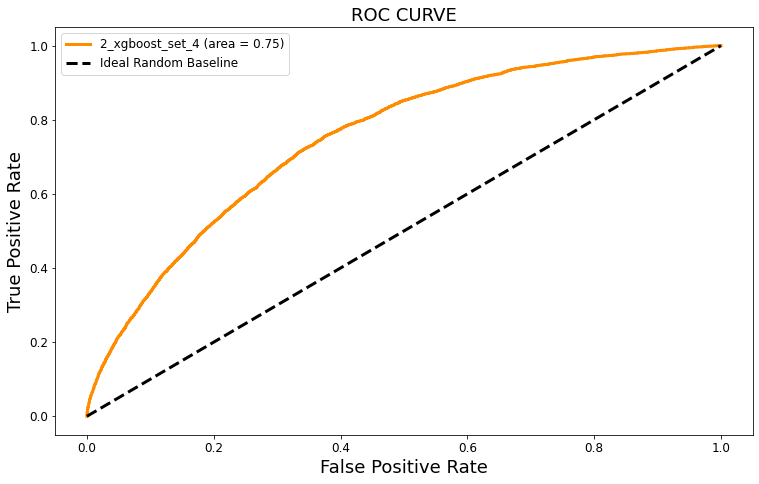

In [50]:
model_name_5 = "2_xgboost_set_4"
perf_eval = Performance_Eval(m4,model_name_5, X_train_2, y_train_2, X_valid_2, y_valid_2,question_no = question_no)
roc_set_4 =  perf_eval.get_roc_auc_plot()

In [51]:
step = "hmtuning"
experiment_2.log_figure(figure = roc_set_1, figure_name=f'Q{question_no}_{step}_ROC_curve_set_1.png')
experiment_2.log_figure(figure = roc_set_2, figure_name=f'Q{question_no}_{step}_ROC_curve_set_2.png')
experiment_2.log_figure(figure = roc_set_3, figure_name=f'Q{question_no}_{step}_ROC_curve_set_3.png')
experiment_2.log_figure(figure = roc_set_4, figure_name=f'Q{question_no}_{step}_ROC_curve_set_4.png')

{'web': 'https://www.comet.ml/api/image/download?imageId=5f1e5fc0b50b4866b6933b680594c96f&experimentKey=34b7aed116e34f6fa2db493d25589751',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=5f1e5fc0b50b4866b6933b680594c96f&experimentKey=34b7aed116e34f6fa2db493d25589751',
 'imageId': '5f1e5fc0b50b4866b6933b680594c96f'}

#### Result: param_list[3] turns out the most effective

# To avoid heavy class imbalance problem, tuning class weights scale

### Class weights

In [52]:
from sklearn.utils import class_weight

# assigining class weight to balanced does NOT yield any good results/makes NO difference (#BLOG)

classes_weights = class_weight.compute_sample_weight(
    # based on ratio of train set class distribution
    class_weight={0:0.10, 1:0.90},
    y=y_train_2
)

In [53]:
model_2_cw = XGBClassifier(**param_list[3])

model_2_cw.fit(X_train_2, y_train_2, sample_weight=classes_weights)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=2, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=30, min_child_weight=0.25, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [54]:
y_pred_cw = model_2_cw.predict(X_valid_2)


### Evaluation - XGBoost post Class Weights (5.2)

In [55]:
y_pred_proba_cw = model_2_cw.predict_proba(X_valid_2)[:,1]
roc_auc =  roc_auc_score(y_valid_2,y_pred_proba_cw)
y_pred_cw = model_2_cw.predict(X_valid_2)
accuracy =  accuracy_score(y_valid_2, y_pred_cw)
report = classification_report(y_valid_2, y_pred_cw, output_dict=True)

print(roc_auc, accuracy)
report

#result: 0.7605648908916087 0.7943124102608062

0.759136323029681 0.7915050468251077


{'0': {'precision': 0.9430624353600784,
  'recall': 0.8194007614633338,
  'f1-score': 0.8768932923357249,
  'support': 42287},
 '1': {'precision': 0.2302187279508114,
  'recall': 0.5219378427787934,
  'f1-score': 0.3195075890046863,
  'support': 4376},
 'accuracy': 0.7915050468251077,
 'macro avg': {'precision': 0.5866405816554449,
  'recall': 0.6706693021210637,
  'f1-score': 0.5982004406702056,
  'support': 46663},
 'weighted avg': {'precision': 0.8762128100976017,
  'recall': 0.7915050468251077,
  'f1-score': 0.8246223316650302,
  'support': 46663}}

In [56]:
metrics = {
    "roc_auc": roc_auc,
    "accuracy": accuracy,
    "classification report": report
}

In [57]:
experiment_2.log_metrics(metrics)

COMET WARNING: Cannot safely convert {'0': {'precision': 0.9430624353600784, 'recall': 0.8194007614633338, 'f1-score': 0.8768932923357249, 'support': 42287}, '1': {'precision': 0.2302187279508114, 'recall': 0.5219378427787934, 'f1-score': 0.3195075890046863, 'support': 4376}, 'accuracy': 0.7915050468251077, 'macro avg': {'precision': 0.5866405816554449, 'recall': 0.6706693021210637, 'f1-score': 0.5982004406702056, 'support': 46663}, 'weighted avg': {'precision': 0.8762128100976017, 'recall': 0.7915050468251077, 'f1-score': 0.8246223316650302, 'support': 46663}} object to a scalar value, using its string representation for logging.


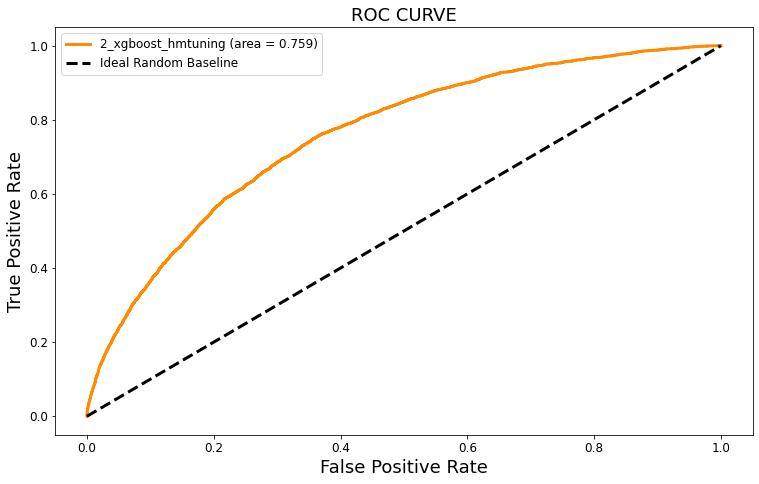

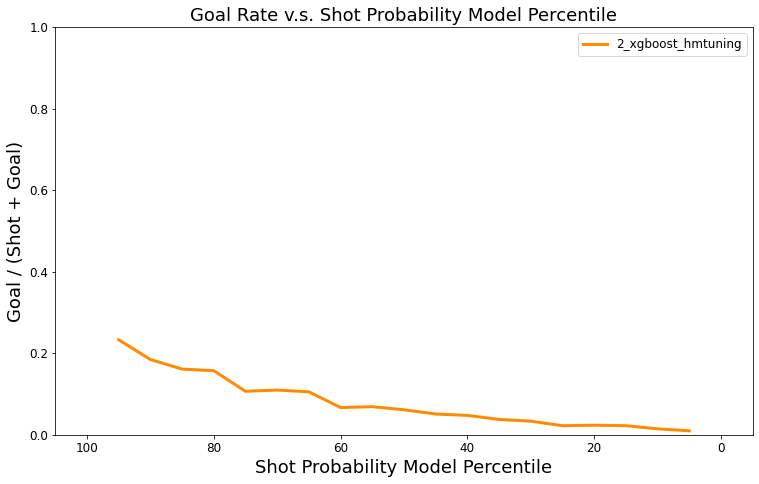

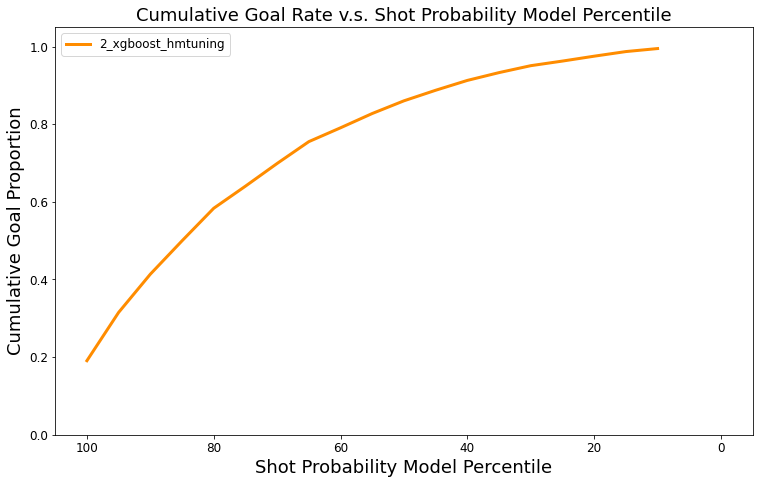

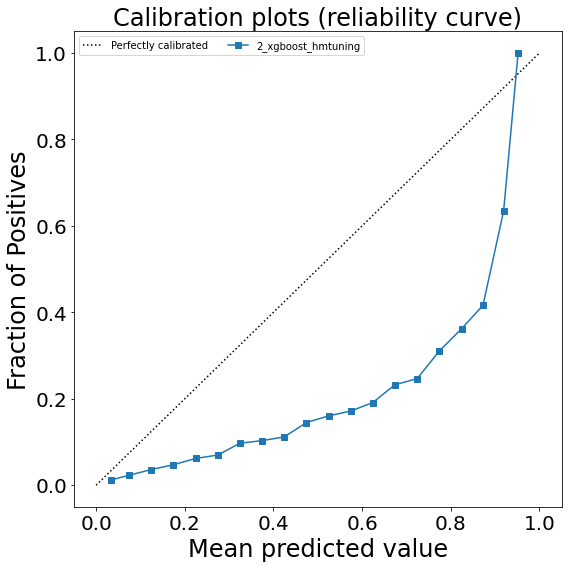

In [58]:
#### USAGE ####
model_name_6 = '2_xgboost_hmtuning'
perf_eval = Performance_Eval(model_2_cw, model_name_6, X_train_2, y_train_2, X_valid_2, y_valid_2, question_no = question_no)
roc = perf_eval.get_roc_auc_plot()
grp = perf_eval.get_goal_rate_plot()
crp = perf_eval.get_cum_rate_plot()
cr = perf_eval.get_calibration_plot()

### Log Model and Plots

In [59]:
experiment_2.log_figure(figure = roc, figure_name=f'Q{question_no}_{model_name_6}_ROC_curve.png')
experiment_2.log_figure(figure = grp, figure_name=f'Q{question_no}_{model_name_6}_Goal_Rate.png')
experiment_2.log_figure(figure = crp, figure_name=f'Q{question_no}_{model_name_6}_Cum_Goal.png')
experiment_2.log_figure(figure = cr, figure_name=f'Q{question_no}_{model_name_6}_Calibration_Curve.png')


{'web': 'https://www.comet.ml/api/image/download?imageId=997c6257ec874fa390a00a5117ca77a5&experimentKey=34b7aed116e34f6fa2db493d25589751',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=997c6257ec874fa390a00a5117ca77a5&experimentKey=34b7aed116e34f6fa2db493d25589751',
 'imageId': '997c6257ec874fa390a00a5117ca77a5'}

In [60]:
pickle.dump(model_2_cw, open("XGBoost_hmtuning_model_v2.pickle", 'wb'))
t = pickle.load(open("XGBoost_hmtuning_model_v2.pickle", 'rb'))

experiment_2.log_model(name = "XGBoost_hmtuning_model_v2", file_or_folder = "XGBoost_hmtuning_model_v2.pickle")

{'web': 'https://www.comet.ml/api/asset/download?assetId=7acb68aec39f48eca703cc6a97103ff5&experimentKey=34b7aed116e34f6fa2db493d25589751',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=7acb68aec39f48eca703cc6a97103ff5&experimentKey=34b7aed116e34f6fa2db493d25589751',
 'assetId': '7acb68aec39f48eca703cc6a97103ff5'}

In [61]:
experiment_2.end

<bound method BaseExperiment.end of <comet_ml.Experiment object at 0x7f8d4f6a9820>>

In [62]:
experiment_2.url

'https://www.comet.ml/kleitoun/milestone-2/34b7aed116e34f6fa2db493d25589751'

# Feature Selection (5.3)

### Create Experiment

In [63]:
experiment_3 = Experiment(api_key = os.environ.get('COMET_API_KEY'), 
                        project_name = "milestone-2", 
                        workspace="kleitoun")

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/kleitoun/milestone-2/34b7aed116e34f6fa2db493d25589751
COMET INFO:   Metrics:
COMET INFO:     accuracy              : 0.7915050468251077
COMET INFO:     classification report : {"0": {"f1-score": 0.8768932923357249, "precision": 0.9430624353600784, "recall": 0.8194007614633338, "support": 42287}, "1": {"f1-score": 0.3195075890046863, "precision": 0.2302187279508114, "recall": 0.5219378427787934, "support": 4376}, "accuracy": 0.7915050468251077, "macro avg": {"f1-score": 0.5982004406702056, "precision": 0.5866405816554449, "recall": 0.6706693021210637, "support": 46663}, "weighted avg": {"f1-score": 0.8246223316650302, "precision": 0.8762128100976017, "recall": 0.7915050468251077, "support": 46663}}
COMET INFO:     roc_auc               : 0.75913632

### Visualize Feature Importance

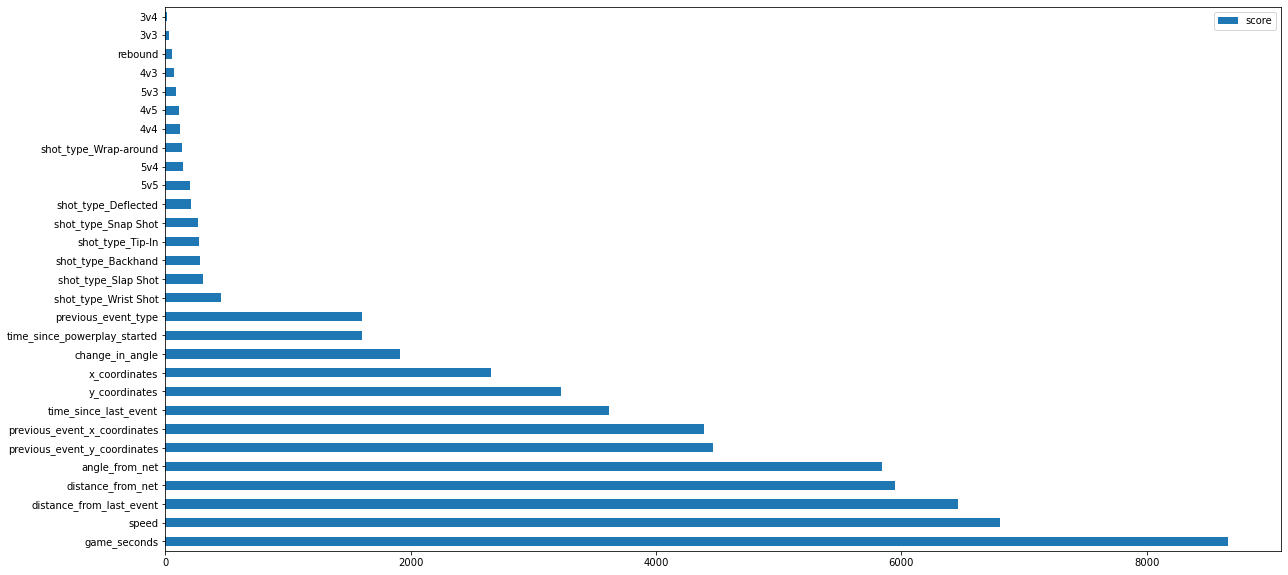

In [68]:
feature_important = model_2_cw.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

viz = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
plt = viz.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features
plt.figure.savefig("../../ift6758-blog-template-main/figures/milestone2/Q5_feature_importance.png")

In [69]:
experiment_3.log_image("../../ift6758-blog-template-main/figures/milestone2/Q5_feature_importance.png")

{'web': 'https://www.comet.ml/api/image/download?imageId=81e16ff33b4f4f9d82a391fc7a0d3a57&experimentKey=d2a029bd135f4cb6a14e41c88ca59e9a',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=81e16ff33b4f4f9d82a391fc7a0d3a57&experimentKey=d2a029bd135f4cb6a14e41c88ca59e9a',
 'imageId': '81e16ff33b4f4f9d82a391fc7a0d3a57'}

In [66]:
## To also visualize the importance of class weight and stratifying the data, 
# the difference between the feature importance graphs could be helpful(#BLOG)
# explainer_2 = shap.Explainer(model_2_cw)
# shap_values_2 = explainer_2(X_train_2)

# shap.summary_plot(shap_values_2, X_train_2)

### Applying Recursive Feature Elimination

In [67]:
#adapted from https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
from tqdm import tqdm
from sklearn.feature_selection import SelectFromModel
#
thresholds = np.sort(model_2_cw.feature_importances_)
for thresh in tqdm(thresholds):
    # select features using threshold
    selection = SelectFromModel(model_2_cw, threshold=thresh, prefit=True)
    select_X_train_2 = selection.transform(X_train_2)
    # train model
    selection_model = XGBClassifier(**hp_params)
    selection_model.fit(select_X_train_2, y_train_2, sample_weight=classes_weights)
    # eval model
    select_X_valid_2 = selection.transform(X_valid_2)
    y_pred = selection_model.predict(select_X_valid_2)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_valid_2, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train_2.shape[1], accuracy*100.0))

  0%|          | 0/31 [00:00<?, ?it/s]X has feature names, but SelectFromModel was fitted without feature names
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
X has feature names, but SelectFromModel was fitted without feature names
  3%|▎         | 1/31 [03:13<1:36:44, 193.48s/it]

Thresh=0.000, n=31, Accuracy: 86.31%


X has feature names, but SelectFromModel was fitted without feature names
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
X has feature names, but SelectFromModel was fitted without feature names
  6%|▋         | 2/31 [06:20<1:31:44, 189.81s/it]

Thresh=0.000, n=31, Accuracy: 86.31%


X has feature names, but SelectFromModel was fitted without feature names
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  6%|▋         | 2/31 [09:06<2:12:10, 273.45s/it]


KeyboardInterrupt: 

### Retrain based on the optimal accuracy value

In [ ]:
## second best thresh value is prioritzed here, as the best value allows only one feature which can make the model biased
thresh = 0.020
selection = SelectFromModel(model_2_cw, threshold=thresh, prefit=True)
select_X_train_2 = selection.transform(X_train_2)

selection_model = XGBClassifier(**param_list[3])
selection_model.fit(select_X_train_2, y_train_2, sample_weight=classes_weights)


In [ ]:
cols = selection.get_support(indices=True)
transformed_X_train_2 = X_train_2.iloc[:,cols]
transformed_X_valid_2 = X_valid_2.iloc[:,cols]

In [ ]:
#### USAGE ####
model_name_7 = "3_xgboost_fs"
perf_eval = Performance_Eval(selection_model,model_name_7, transformed_X_train_2, y_train_2, transformed_X_valid_2, y_valid_2, question_no)
roc = perf_eval.get_roc_auc_plot()
grp= perf_eval.get_goal_rate_plot()
crp = perf_eval.get_cum_rate_plot()
cr = perf_eval.get_calibration_plot()

### Log Model and Plots

In [ ]:

experiment_3.log_figure(figure = roc, figure_name=f'Q{question_no}_{model_name_7}_ROC_curve.png')
experiment_3.log_figure(figure = grp, figure_name=f'Q{question_no}_{model_name_7}_Goal_Rate.png')
experiment_3.log_figure(figure = crp, figure_name=f'Q{question_no}_{model_name_7}_Cum_Goal.png')
experiment_3.log_figure(figure = cr, figure_name=f'Q{question_no}_{model_name_7}_Calibration_Curve.png')

In [ ]:
pickle.dump(selection_model, open("XGBoost_feature_selection_model_v2.pickle", 'wb'))
t = pickle.load(open("XGBoost_feature_selection_model_v2.pickle", 'rb'))

experiment_3.log_model(name = "XGBoost_feature_selection_model_v2", file_or_folder = "XGBoost_feature_selection_model_v2.pickle")

In [ ]:
experiment_3.url

In [ ]:
y_pred_proba_cw = selection_model.predict_proba(transformed_X_valid_2)[:,1]
roc_auc =  roc_auc_score(y_valid_2,y_pred_proba_cw)
y_pred_cw = selection_model.predict(transformed_X_valid_2)
accuracy =  accuracy_score(y_valid_2, y_pred_cw)
report = classification_report(y_valid_2, y_pred_cw, output_dict=True)

print(roc_auc, accuracy)
report

#result: 0.7593543260298987 0.7885262413475345

In [ ]:
metrics = {
    "roc_auc": roc_auc,
    "accuracy": accuracy,
    "classification report": report
}

In [ ]:
experiment_3.log_metrics(metrics)

# Experiment 4 for improvement

# SMOTE

## Does not give much of an improvement

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# define dataset

In [ ]:
X_2 = impute_df(X_2)

In [ ]:
model = XGBClassifier(n_estimators= 150, max_depth= 4, learning_rate= 0.2, subsample= 1.0, min_child_weight= 5, gamma= 5, colsample_bytree= 1.0)
over = SMOTE(sampling_strategy="auto")
under = RandomUnderSampler(sampling_strategy="auto")
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X_train_2, y_train_2, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

In [ ]:
from imblearn.over_sampling import ADASYN
from collections import Counter
# summarize class distribution
counter = Counter(y_2)
print(counter)
# transform the dataset
oversample = ADASYN()
X_train_smote, y_train_smote = oversample.fit_resample(X_2, y_2)
# summarize the new class distribution
counter = Counter(y_train_smote)
print(counter)